In [1]:
pip install ib_insync

In [83]:
from ib_insync import *

# Utilize an instance of IB
ib = IB()

# Connect to the IB server using await in front of the connectAsync method
try:
    await ib.connectAsync('127.0.0.1', 7497, clientId=1)
    print("Connected to Interactive Brokers API")
except Exception as e:
    print("There has is an error when connecting to IB API")

Connected to Interactive Brokers API


In [88]:
from ib_insync import *
import pytz
import pandas as pd
contract = Future('ES', '202406', 'CME')

await ib.qualifyContractsAsync(contract)
# Assume 'ib' is already connected and is an instance of ib_insync.IB()
# Also assume 'contract' has been created and is a valid ib_insync.Contract object

# Use the asynchronous version of the method with await
try:
    historical_data = await ib.reqHistoricalDataAsync(
        contract, endDateTime='', durationStr='30 D',
        barSizeSetting='1 hour', whatToShow='MIDPOINT', useRTH=True
    )
    
    # Proceed with the historical data
#     for bar in historical_data:
#         print(bar)
except Exception as e:
    print(f"An error occurred: {e}")



# Assuming 'historical_data' contains the historical data returned by reqHistoricalDataAsync

# Convert timestamps to the desired time zone (e.g., 'US/Eastern')
tz = pytz.timezone('US/Eastern')
for bar in historical_data:
    bar.date = bar.date.astimezone(tz)

# Convert historical data to DataFrame
df = pd.DataFrame([vars(bar) for bar in historical_data])

# Print the DataFrame
print(df)
market_data = ib.reqMktData(contract)
print(market_data.bid)
print(market_data.ask)

                         date     open     high      low    close  volume  \
0   2024-03-19 09:30:00-04:00  5205.75  5206.25  5195.00  5200.75    -1.0   
1   2024-03-19 10:00:00-04:00  5200.75  5210.00  5195.50  5206.00    -1.0   
2   2024-03-19 11:00:00-04:00  5206.00  5218.50  5205.25  5215.75    -1.0   
3   2024-03-19 12:00:00-04:00  5215.75  5235.75  5213.75  5231.25    -1.0   
4   2024-03-19 13:00:00-04:00  5231.25  5239.00  5227.75  5234.25    -1.0   
..                        ...      ...      ...      ...      ...     ...   
234 2024-04-30 11:00:00-04:00  5131.75  5132.00  5105.00  5111.00    -1.0   
235 2024-04-30 12:00:00-04:00  5111.00  5115.25  5092.50  5097.75    -1.0   
236 2024-04-30 13:00:00-04:00  5097.75  5107.50  5091.50  5106.00    -1.0   
237 2024-04-30 14:00:00-04:00  5106.00  5110.25  5088.50  5092.75    -1.0   
238 2024-04-30 15:00:00-04:00  5092.75  5097.75  5086.50  5088.50    -1.0   

     average  barCount  
0       -1.0        -1  
1       -1.0        -1  


Error 10168, reqId 14: Requested market data is not subscribed. Delayed market data is not enabled., contract: Future(conId=551601561, symbol='ES', lastTradeDateOrContractMonth='20240621', multiplier='50', exchange='CME', currency='USD', localSymbol='ESM4', tradingClass='ES')
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: usfarm.nj; usfuture; cashfarm; usfarm; ushmds; secdefil.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: usfarm.nj; usfuture; cashfarm; usfarm; ushmds; secdefil.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has 

In [44]:
# df = util.df(historical_data)
# print(df)
#Historical future price data last updated on 4/26/2024, the inclusion of method shows an implementation of how the data is preprocessed
def preprocess_and_save_data(data, filename):
    data.to_csv(filename, index=False)
# preprocess_and_save_data(df, 'ib_es500_price_history.csv')

In [15]:
!pip install nest_asyncio

In [110]:
#E2
import nest_asyncio
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
nest_asyncio.apply()
class LSTMModel():
    ##
    def __init__(self, sequence_size=60, lstm_units=50, dense_units=25):
        self.sequence_size = sequence_size
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.model = None
        self.scaler = None
    # Preprocess data for model training
    def preprocess_data(self,filepath):
        data = pd.read_csv(filepath)
        features = data[['close', 'high', 'low', 'volume']].values # Fetch 4 columns from dataframe
        scaler = MinMaxScaler(feature_range=(0, 1))# Initialize scaler and normalize data to a range of 0 to 1.
        scaled_features = scaler.fit_transform(features)# Scaling each feature to the range (0,1) depending on the values 
        return scaled_features, scaler

    # Create sequences for LSTM training
    def create_sequences(self,data):
        inputSequence = [] #initialize input sequence
        targetSequence = [] #initialize target sequence
        sequence_size=60
        sequenceFormationLength = len(data) - sequence_size;
        for i in range(sequenceFormationLength): # iteration of data to form sequence    
            inputSequence.append(data[i:(i + sequence_size)]) # Appending a piece of data from i to i + sequence_size
            targetSequence.append(data[i + sequence_size, 0])# Used for prediction of the future close price
        return np.array(inputSequence), np.array(targetSequence)

    # Define LSTM model structure
    def build_lstm_model(self,input_shape):
        lstmLayerWithSequence = LSTM(50, return_sequences=True, input_shape=input_shape)
        self.model = Sequential([
            lstmLayerWithSequence, # LSTM layer with 50 neurons and returning full sequence which passed into the next layer as an input
            Dropout(0.2), # Dropout layer added to prevent overfitting
            LSTM(50), # Only the last output of the output sequence is returned and reduce dimensionality
            Dropout(0.2), # Dropout layer added to prevent overfitting
            Dense(25), # Fully-connected layer with 25 neurons that process the features fetched by the recurrent layers through interpretation and process of the output of prediction.
            Dense(1) # Fully-connected layer with 1 neuron that outputs the predicted value
        ])
        self.model.compile(optimizer='adam', loss='mean_squared_error') # Compile with Adam optimizer and configured the model for training
    ##
    def train(self, inputs, targets, validation_data, epochs=10, batch_size=32):
        return self.model.fit(inputs, targets, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

    #Plotting model learning
    def plot_model_learning(self, history, learning_rate_schedule=None):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        if learning_rate_schedule is not None:
            plt.subplot(1, 2, 2)
            plt.plot(learning_rate_schedule, label='Learning Rate')
            plt.title('Learning Rate Schedule')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()

        plt.tight_layout()
        plt.show()

    # Function to inverse transform prices
    def inverse_transform_price(self, scaler, price, n_features):
        # Create a dummy array with the same number of features
        dummy = np.zeros((len(price), n_features))
        # Place the price in the correct column (assuming 'close' is the first column)
        dummy[:, 0] = price
        # Inverse transform and return the correct column
        return scaler.inverse_transform(dummy)[:, 0]

    # Plot predictions
    def plot_predictions(self, actual, predicted):
        plt.figure(figsize=(10, 5))
        plt.plot(actual, label='Actual Price', color='blue')
        plt.plot(predicted, label='Predicted Price', color='red')
        plt.title('Actual vs Predicted Prices')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
        
    def predict(self, data):
        return self.model.predict(data)


2024-04-30 23:05:20.597640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 23:05:20.599219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 23:05:20.600222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-04-30 23:05:20.814515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 23:05:20.816629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 23:05:20.818126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - ETA: 0s - loss: 0.0915

2024-04-30 23:05:24.387736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 23:05:24.388783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 23:05:24.390043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 148ms/step - loss: 0.0915 - val_loss: 0.0397
Epoch 2/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0371 - val_loss: 0.0259
Epoch 3/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0298 - val_loss: 0.0150
Epoch 4/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0184 - val_loss: 0.0133
Epoch 5/50
6/6 [==============================] - 0s 32ms/step - loss: 0.0194 - val_loss: 0.0105
Epoch 6/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0172 - val_loss: 0.0119
Epoch 7/50
6/6 [==============================] - 0s 30ms/step - loss: 0.0171 - val_loss: 0.0093
Epoch 8/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0172 - val_loss: 0.0085
Epoch 9/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 10/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0162 - val_loss: 0.0080
Epoch 11/50
6/6 [======================

2024-04-30 23:05:34.895403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 23:05:34.896494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 23:05:34.897817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 12ms/step


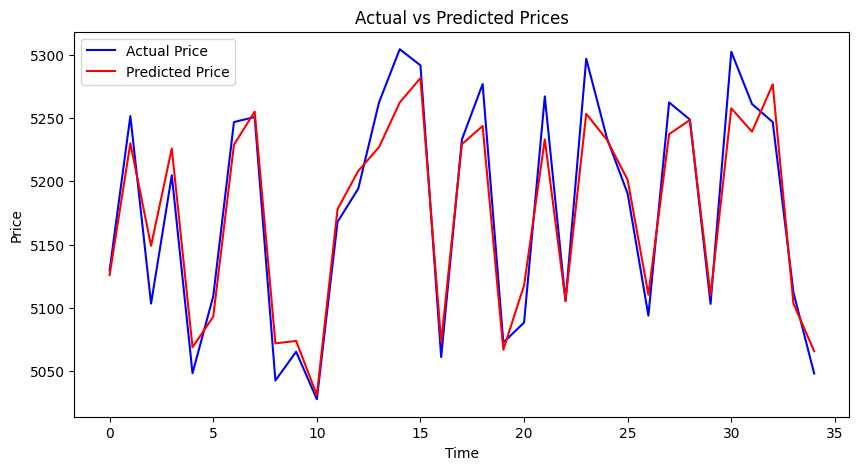

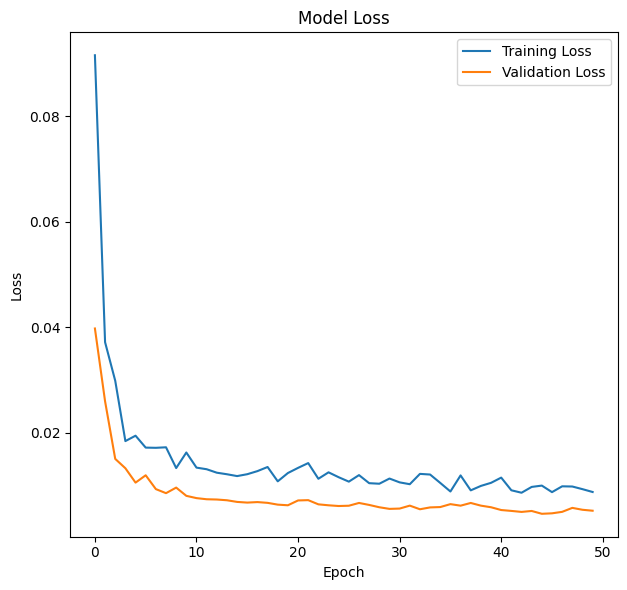

Error 354, reqId 22: Requested market data is not subscribed.Delayed market data is available.ES JUN'24/TOP/ALL, contract: Future(symbol='ES', lastTradeDateOrContractMonth='202406', exchange='CME')


1/1 [==============================] - 0s 24ms/step
5136.342775695027 nan
Decision: HOLD, Shares: 0, Predicted Price: 5136.342775695027
Decision is to HOLD, no action taken.
Order HOLD for 0 shares has been filled.


In [111]:
# Adjust the prediction function to handle new features
def predict_and_decide(model, scaler, data, current_price, available_funds, current_shares, total_cost, transaction_fee=2.25):
    scaled_data = data.reshape(1, 60, -1)  # Reshape scaled data passed into LSTM model as an input
    scaled_prediction = model.predict(scaled_data) # Model makes prediction based on scaled data
    # Focus only on close price, which is the first feature),use a dummy array for inverse transform
    dummy_features = np.zeros((1, 4))  # Use 4 features as per scaler fitting, one row and four columns, which correspond to the 4 features
    dummy_features[0, 0] = scaled_prediction[0][0]  # Predicted price goes into the position of close price
    
    predicted_price = scaler.inverse_transform(dummy_features)[0, 0]  # Inverse transform and fetch the close price, the scaled prediction is converted back to the original scale of the data
    print(predicted_price, current_price)
    # Decision making based on predicted and current price with transaction fees taken into consideration
    decision = "HOLD"
    shares = 0
    if predicted_price > current_price:
        if available_funds > transaction_fee and available_funds / current_price >= 50:
            max_affordable_shares = int((available_funds * 0.3 - transaction_fee) / current_price)
            decision = "BUY"
            shares = max_affordable_shares 
    elif predicted_price < current_price:
        decision = "SELL"
        shares = int(current_shares * 0.1) 
        
    return decision, shares, predicted_price

# Example usage of the functions
if __name__ == "__main__":
    filepath = 'ib_es500_price_history.csv'
    scaled_features, scaler = preprocess_data(filepath)
    inputs, targets = create_sequences(scaled_features)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = LSTMModel(sequence_size=60, lstm_units=50, dense_units=25)
    input_shape = x_train.shape[1], x_train.shape[2]
    model.build_lstm_model(input_shape)
    history = model.train(inputs, targets, (x_test, y_test), epochs=50, batch_size=32)
#     history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))  # Reduced epochs, added explicit test data for validation
    
    # Generate and plot predictions
    
    predicted_scaled = model.predict(x_test)

    # Inverse transform predictions and actual values
    predicted_prices = inverse_transform_price(scaler, predicted_scaled.flatten(), 4)
    actual_prices = inverse_transform_price(scaler, y_test, 4)

    # Plotting function remains the same
    plot_predictions(actual_prices, predicted_prices)

    # Display training and validation loss
    plot_model_learning(history)

    # Simulating a scenario for prediction and decision making
    positions = ib.positions()
    for pos in positions:
        if pos.contract.symbol == 'ES' and pos.contract.secType == 'FUT':
            current_shares = pos.position
    account_summary = await ib.accountSummaryAsync()
    # Find the total cash balance
    balance = next((item for item in account_summary if item.tag == 'TotalCashBalance'), None)
    
    contract = Future('ES', '202406', 'CME')
    market_data = ib.reqMktData(contract, '', False, False)
    util.sleep(5)
    current_price = (market_data.bid + market_data.ask) / 2
    
    
    available_funds = balance.value
    total_cost = current_shares * current_price  # Simulated total cost of current shares
    
    # Prepare recent data for prediction
    recent_data = scaled_features[-60:]  # Make sure this is exactly 60 timesteps
    decision, shares, predicted_price = predict_and_decide(model, scaler, recent_data, current_price, available_funds, current_shares, total_cost)
    print(f"Decision: {decision}, Shares: {shares}, Predicted Price: {predicted_price}")
    
    # Execute the decision
    if decision == "BUY":
        order = MarketOrder('BUY', shares)
        trade = ib.placeOrder(contract, order)
    elif decision == "SELL":
        order = MarketOrder('SELL', shares)
        trade = ib.placeOrder(contract, order)
    elif decision == "HOLD":
        print("Decision is to HOLD, no action taken.")

    # Monitor the order until it is filled
    ib.sleep(1)  # Sleeping to give time for the order to be executed


    print(f"Order {decision} for {shares} shares has been filled.")